## Step 1: Download Data from TFL 

In [1]:
import os
import requests
from tqdm import tqdm
from datetime import datetime, timedelta

BASE_URL = "https://cycling.data.tfl.gov.uk/usage-stats/"
TARGET_DIR = "tfl_cycle_data"
START_DATE = datetime(2020, 12, 30)
END_DATE = datetime(2023, 6, 19)  # Just before 375
START_INDEX = 246

os.makedirs(TARGET_DIR, exist_ok=True)

def format_date(d):
    return d.strftime("%d%b%Y")

current_date = START_DATE
file_index = START_INDEX
download_links = []

# === PHASE 1: Weekly files (246 to 374, with exceptions)
while current_date < END_DATE:
    # Special case for 334 (5-day file)
    if file_index == 334:
        filename = f"{file_index}JourneyDataExtract07Sep2022-11Sep2022.csv"
        download_links.append((BASE_URL + filename, filename))
        current_date = datetime(2022, 9, 12)
        file_index += 1
        continue

    # Normal 7-day range
    start_str = format_date(current_date)
    end_str = format_date(current_date + timedelta(days=6))
    filename = f"{file_index}JourneyDataExtract{start_str}-{end_str}.csv"
    download_links.append((BASE_URL + filename, filename))
    current_date += timedelta(days=7)
    file_index += 1

# Add special case for 375 (12-day file)
download_links.append((
    BASE_URL + "375JourneyDataExtract19Jun2023-30Jun2023.csv",
    "375JourneyDataExtract19Jun2023-30Jun2023.csv"
))

# === PHASE 2: Manually define filenames from 376 onwards 
manual_files = [
    "376JourneyDataExtract01Jul2023-14Jul2023.csv",
    "377JourneyDataExtract15Jul2023-31Jul2023.csv",
    "378JourneyDataExtract01Aug2023-14Aug2023.csv",
    "378JourneyDataExtract15Aug2023-31Aug2023.csv",
    "379JourneyDataExtract01Sep2023-14Sep2023.csv",
    "380JourneyDataExtract15Sep2023-30Sep2023.csv",
    "381JourneyDataExtract01Oct2023-14Oct2023.csv",
    "382JourneyDataExtract15Oct2023-31Oct2023.csv",
    "383JourneyDataExtract01Nov2023-14Nov2023.csv",
    "384JourneyDataExtract15Nov2023-30Nov2023.csv",
    "385JourneyDataExtract01Dec2023-14Dec2023.csv",
    "386JourneyDataExtract15Dec2023-31Dec2023.csv",
    "387JourneyDataExtract01Jan2024-14Jan2024.csv",
    "388JourneyDataExtract15Jan2024-31Jan2024.csv"
]

for file in manual_files:
    download_links.append((BASE_URL + file, file))

# === DOWNLOAD BLOCK
print(f"Attempting to download {len(download_links)} files...")

for url, filename in tqdm(download_links):
    path = os.path.join(TARGET_DIR, filename)
    if os.path.exists(path):
        continue
    try:
        with requests.get(url, stream=True) as r:
            r.raise_for_status()
            with open(path, "wb") as f:
                for chunk in r.iter_content(chunk_size=8192):
                    f.write(chunk)
    except Exception as e:
        print(f"❌ Failed to download {filename}: {e}")

print("✅ All available files downloaded to:", TARGET_DIR)


Attempting to download 144 files...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [01:16<00:00,  1.88it/s]

✅ All available files downloaded to: tfl_cycle_data


In [2]:
import os
import pandas as pd

# Path to your downloaded CSVs
data_dir = "tfl_cycle_data"

# Get all .csv files
csv_files = [f for f in os.listdir(data_dir) if f.endswith(".csv")]

# Combine them into one DataFrame
combined_df = pd.DataFrame()
for file in csv_files:
    path = os.path.join(data_dir, file)
    try:
        df = pd.read_csv(path , low_memory=False)
        df["source_file"] = file  # Track file of origin
        combined_df = pd.concat([combined_df, df], ignore_index=True)
    except Exception as e:
        print(f"Error reading {file}: {e}")

# Save combined file (optional)
combined_df.to_csv("combined_tfl_cycle_data.csv", index=False)
print("✅ Combined CSV saved as combined_tfl_cycle_data.csv")


✅ Combined CSV saved as combined_tfl_cycle_data.csv


## Step 2: Data Preprocessing

In [3]:
import pandas as pd 

combined_df = pd.read_csv("combined_tfl_cycle_data.csv", low_memory=False)

combined_df.head()

,Rental Id,Duration,Bike Id,End Date,EndStation Id,EndStation Name,Start Date,StartStation Id,StartStation Name,source_file,...,Start date,Start station number,Start station,End date,End station number,End station,Bike number,Bike model,Total duration,Total duration (ms)
0,109096951.0,540.0,13318.0,15/06/2021 20:19,661.0,"All Saints Church, Portobello",15/06/2021 20:10,105.0,"Westbourne Grove, Bayswater",269JourneyDataExtract09Jun2021-15Jun2021.csv,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,108982015.0,780.0,18991.0,13/06/2021 13:03,312.0,"Grove End Road, St. John's Wood",13/06/2021 12:50,106.0,"Woodstock Street, Mayfair",269JourneyDataExtract09Jun2021-15Jun2021.csv,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,108839141.0,840.0,16736.0,10/06/2021 15:28,333.0,"Palace Gardens Terrace, Notting Hill",10/06/2021 15:14,106.0,"Woodstock Street, Mayfair",269JourneyDataExtract09Jun2021-15Jun2021.csv,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,108816591.0,1380.0,913.0,09/06/2021 22:37,51.0,"Finsbury Library , Finsbury",09/06/2021 22:14,123.0,"St. John Street, Finsbury",269JourneyDataExtract09Jun2021-15Jun2021.csv,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,108919084.0,1200.0,6682.0,12/06/2021 11:29,732.0,"Duke Street Hill, London Bridge",12/06/2021 11:09,123.0,"St. John Street, Finsbury",269JourneyDataExtract09Jun2021-15Jun2021.csv,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Loop over each column and print unique sample values to see how each columns looks like. 
for col in combined_df.columns:
    print(f"\n📌 Column: {col}")
    print("-" * (10 + len(col)))
    try:
        # Display data type and number of unique values
        print(f"Type: {combined_df[col].dtype}")
        print(f"Unique values: {combined_df[col].nunique()}")
        
        # Show sample unique values (up to 10)
        sample_values = combined_df[col].dropna().unique()[:10]
        for val in sample_values:
            print(f"  - {val}")
    except Exception as e:
        print(f"⚠️ Error processing column '{col}': {e}")



📌 Column: Rental Id
-------------------
Type: float64
Unique values: 19727277
  - 109096951.0
  - 108982015.0
  - 108839141.0
  - 108816591.0
  - 108919084.0
  - 108862447.0
  - 108989560.0
  - 109044915.0
  - 109044901.0
  - 108794152.0

📌 Column: Duration
------------------
Type: float64
Unique values: 4494
  - 540.0
  - 780.0
  - 840.0
  - 1380.0
  - 1200.0
  - 300.0
  - 960.0
  - 360.0
  - 720.0
  - 1020.0

📌 Column: Bike Id
-----------------
Type: float64
Unique values: 17033
  - 13318.0
  - 18991.0
  - 16736.0
  - 913.0
  - 6682.0
  - 2046.0
  - 15460.0
  - 19982.0
  - 17193.0
  - 4211.0

📌 Column: End Date
------------------
Type: object
Unique values: 838859
  - 15/06/2021 20:19
  - 13/06/2021 13:03
  - 10/06/2021 15:28
  - 09/06/2021 22:37
  - 12/06/2021 11:29
  - 10/06/2021 22:38
  - 13/06/2021 15:04
  - 14/06/2021 18:19
  - 09/06/2021 16:12
  - 14/06/2021 18:18

📌 Column: EndStation Id
-----------------------
Type: float64
Unique values: 805
  - 661.0
  - 312.0
  - 333.0
  

In [6]:
# Based on the above output - Few columns can be combined - Doing that
import pandas as pd

# 1. Start by combining duplicate/alternate columns
combined_df['Rental Id'] = combined_df['Rental Id'].combine_first(combined_df['Number'])
combined_df['Bike Id'] = combined_df['Bike Id'].combine_first(combined_df['Bike number'])
combined_df['Start Date'] = combined_df['Start Date'].combine_first(combined_df['Start date'])
combined_df['End Date'] = combined_df['End Date'].combine_first(combined_df['End date'])
combined_df['StartStation Id'] = combined_df['StartStation Id'].combine_first(combined_df['Start station number'])
combined_df['StartStation Name'] = combined_df['StartStation Name'].combine_first(combined_df['Start station'])
combined_df['EndStation Id'] = combined_df['EndStation Id'].combine_first(combined_df['End station number'])
combined_df['EndStation Name'] = combined_df['EndStation Name'].combine_first(combined_df['End station'])

# 2. Convert datetime columns to proper format
combined_df['Start Date'] = pd.to_datetime(combined_df['Start Date'], errors='coerce', dayfirst=True)
combined_df['End Date'] = pd.to_datetime(combined_df['End Date'], errors='coerce', dayfirst=True)

# 3. Create a new cleaned DataFrame with only relevant columns
cleaned_df = combined_df[[
    'Rental Id',
    'Start Date',
    'End Date',
    'Duration',                 # Duration in seconds
    'Bike Id',
    'StartStation Id',
    'StartStation Name',
    'EndStation Id',
    'EndStation Name',
    'Bike model',              
    'source_file'               
]].copy()

# 4. Rename columns for clarity  
cleaned_df.rename(columns={
    'Rental Id': 'rental_id',
    'Start Date': 'start_time',
    'End Date': 'end_time',
    'Duration': 'duration_sec',
    'Bike Id': 'bike_id',
    'StartStation Id': 'start_station_id',
    'StartStation Name': 'start_station_name',
    'EndStation Id': 'end_station_id',
    'EndStation Name': 'end_station_name',
    'Bike model': 'bike_model',
    'source_file': 'source_file'
}, inplace=True)


cleaned_df.reset_index(drop=True, inplace=True)


In [7]:
cleaned_df.head()

,rental_id,start_time,end_time,duration_sec,bike_id,start_station_id,start_station_name,end_station_id,end_station_name,bike_model,source_file
0,109096951.0,2021-06-15 20:10:00,2021-06-15 20:19:00,540.0,13318.0,105.0,"Westbourne Grove, Bayswater",661.0,"All Saints Church, Portobello",NaN,269JourneyDataExtract09Jun2021-15Jun2021.csv
1,108982015.0,2021-06-13 12:50:00,2021-06-13 13:03:00,780.0,18991.0,106.0,"Woodstock Street, Mayfair",312.0,"Grove End Road, St. John's Wood",NaN,269JourneyDataExtract09Jun2021-15Jun2021.csv
2,108839141.0,2021-06-10 15:14:00,2021-06-10 15:28:00,840.0,16736.0,106.0,"Woodstock Street, Mayfair",333.0,"Palace Gardens Terrace, Notting Hill",NaN,269JourneyDataExtract09Jun2021-15Jun2021.csv
3,108816591.0,2021-06-09 22:14:00,2021-06-09 22:37:00,1380.0,913.0,123.0,"St. John Street, Finsbury",51.0,"Finsbury Library , Finsbury",NaN,269JourneyDataExtract09Jun2021-15Jun2021.csv
4,108919084.0,2021-06-12 11:09:00,2021-06-12 11:29:00,1200.0,6682.0,123.0,"St. John Street, Finsbury",732.0,"Duke Street Hill, London Bridge",NaN,269JourneyDataExtract09Jun2021-15Jun2021.csv


In [8]:
# Define the date range 
start_date = pd.Timestamp("2021-01-01")
end_date = pd.Timestamp("2023-12-31 23:59:59")

# Filter rows where start_time is within the desired date range
filtered_df = cleaned_df[
    (cleaned_df['start_time'] >= start_date) &
    (cleaned_df['start_time'] <= end_date)
].copy()

filtered_df.to_csv('tfl_cycle_rentals_2021_2023_cleaned.csv')

## Exploratory data analysis

/tmp/ipykernel_275675/2135559314.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_start_stations.values, y=top_start_stations.index, palette='viridis')
/tmp/ipykernel_275675/2135559314.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='hour', y='trip_count', data=hourly_trips, palette='coolwarm')


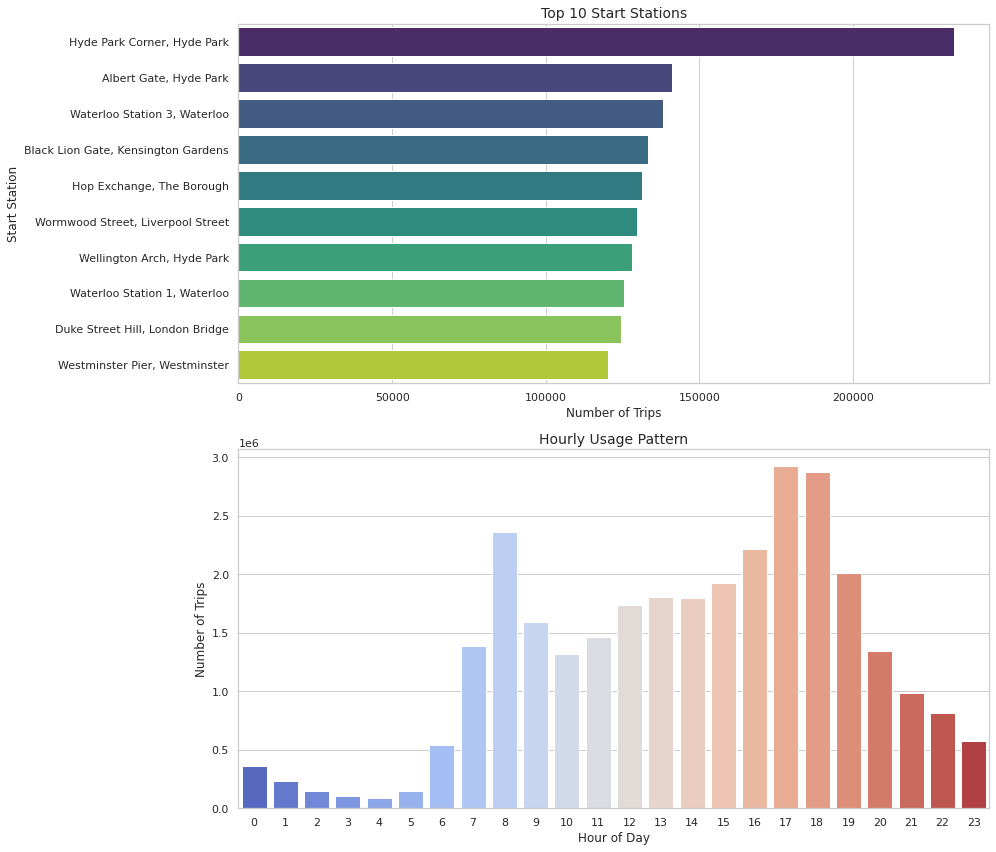

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Creating additional columns for EDA
filtered_df['duration_min'] = filtered_df['duration_sec'] / 60
filtered_df['hour'] = filtered_df['start_time'].dt.hour
filtered_df['month'] = filtered_df['start_time'].dt.to_period("M").astype(str)  # format: 'YYYY-MM'

sns.set(style="whitegrid")
plt.figure(figsize=(14, 12))  # Adjusted height for 2 plots

# Top 10 Start Stations
plt.subplot(2, 1, 1)
top_start_stations = filtered_df['start_station_name'].value_counts().head(10)
sns.barplot(x=top_start_stations.values, y=top_start_stations.index, palette='viridis')
plt.title("Top 10 Start Stations", fontsize=14)
plt.xlabel("Number of Trips")
plt.ylabel("Start Station")

# Hourly Usage Pattern
plt.subplot(2, 1, 2)
hourly_trips = filtered_df.groupby('hour').size().reset_index(name='trip_count')
sns.barplot(x='hour', y='trip_count', data=hourly_trips, palette='coolwarm')
plt.title("Hourly Usage Pattern", fontsize=14)
plt.xlabel("Hour of Day")
plt.ylabel("Number of Trips")

plt.tight_layout()
plt.show()


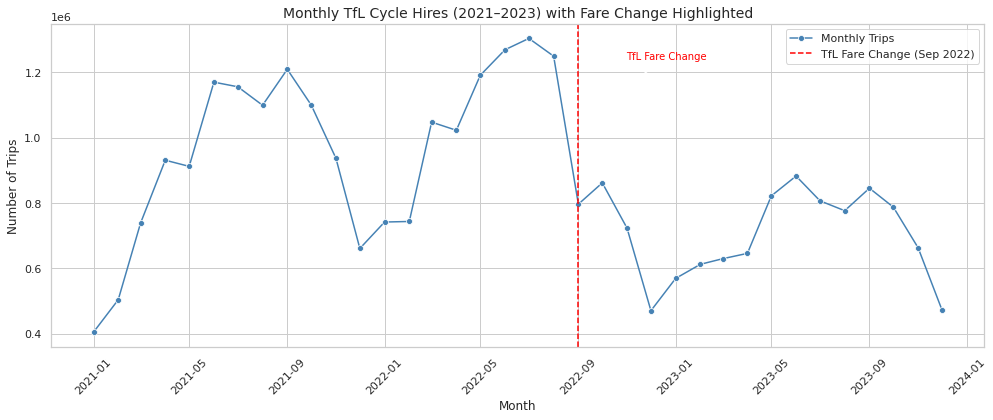

In [15]:
# Monthly TfL Cycle Hires (2021–2023) with Fare Change Highlighted

# 1. Ensure 'month' column exists
filtered_df['month'] = pd.to_datetime(filtered_df['start_time']).dt.to_period('M')
monthly_trips = filtered_df.groupby('month').size().reset_index(name='trip_count')
monthly_trips['month'] = monthly_trips['month'].dt.to_timestamp()

# 2. Define the fare change month
fare_change_month = pd.to_datetime("2022-09")

# 3. Plot with annotation
plt.figure(figsize=(14, 6))
sns.lineplot(data=monthly_trips, x='month', y='trip_count', marker='o', color='steelblue', label="Monthly Trips")

# Vertical line for fare change
plt.axvline(fare_change_month, color='red', linestyle='--', linewidth=1.5, label='TfL Fare Change (Sep 2022)')

# Annotation with arrow
plt.annotate(
    'TfL Fare Change', 
    xy=(fare_change_month, monthly_trips['trip_count'].max()*0.8),
    xytext=(fare_change_month + pd.DateOffset(days=60), monthly_trips['trip_count'].max()*0.95),
    arrowprops=dict(facecolor='red', arrowstyle='->', linewidth=1.5),
    color='red',
    fontsize=10
)

# Final formatting
plt.title("Monthly TfL Cycle Hires (2021–2023) with Fare Change Highlighted", fontsize=14)
plt.xlabel("Month")
plt.ylabel("Number of Trips")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


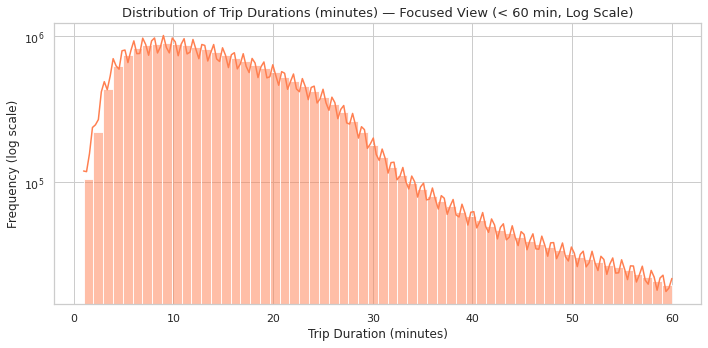

In [18]:
# Distribution of Cycle Trip Durations (minutes) - TfL

# Filter: Keep trips ≤ 60 minutes
duration_cutoff = 60
filtered_subset = filtered_df[filtered_df['duration_min'] <= duration_cutoff]

# Plot: Histogram with better binning and log scale on y-axis
plt.figure(figsize=(10, 5))
sns.histplot(
    data=filtered_subset,
    x='duration_min',
    bins=60,            # One bin per minute
    kde=True,
    color='coral'
)

plt.yscale('log')  # Apply logarithmic scale to y-axis
plt.title("Distribution of Trip Durations (minutes) — Focused View (< 60 min, Log Scale)", fontsize=13)
plt.xlabel("Trip Duration (minutes)")
plt.ylabel("Frequency (log scale)")
plt.tight_layout()
plt.show()


/tmp/ipykernel_275675/373495716.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=filtered_df, x='day', order=day_order, palette='Set2')


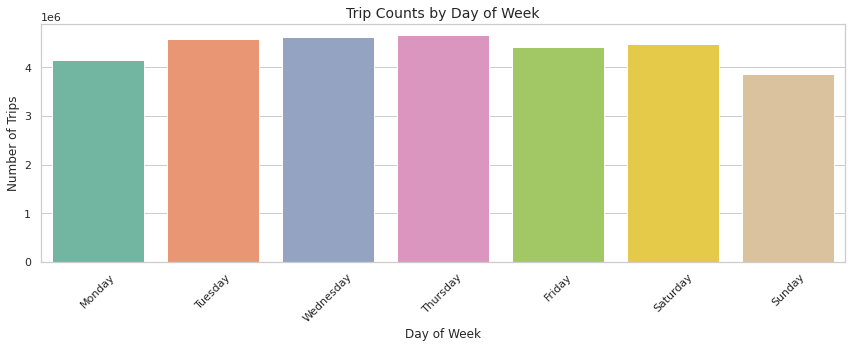

In [21]:
# 5. Day-of-Week Usage 
plt.figure(figsize=(12, 5))
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.countplot(data=filtered_df, x='day', order=day_order, palette='Set2')
plt.title("Trip Counts by Day of Week", fontsize=14)
plt.xlabel("Day of Week")
plt.ylabel("Number of Trips")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Use-Case 1: Station Demand forecasting

🔄 Loading dataset...
🧠 Extracting time-based features...
📊 Aggregating ride counts...
📉 Creating lag-based features...
✅ Features ready. Preparing training data...


/tmp/ipykernel_570838/3320457074.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype('category')


📦 Splitting data into train/test sets...
🔍 Starting hyperparameter tuning with CatBoost...
✅ Hyperparameter tuning complete!
🚀 Evaluating best model...
📈 RMSE: 2.16
📈 R² Score: 0.52
🏆 Best Parameters: {'learning_rate': 0.1, 'l2_leaf_reg': 1, 'iterations': 500, 'depth': 6}
📤 Generating actual vs predicted plot...


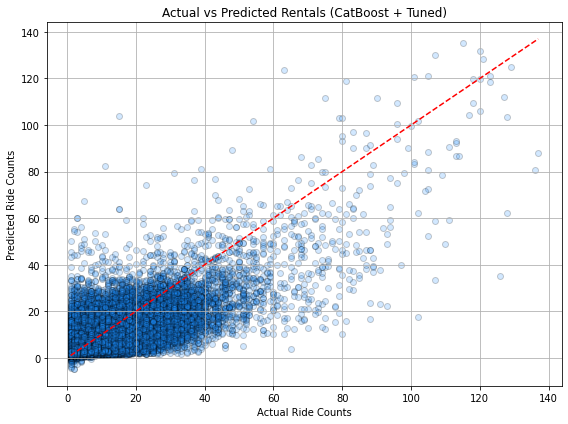

📤 Generating feature importance plot...


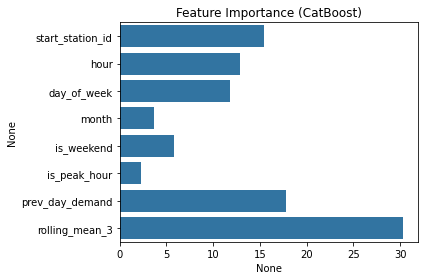

✅ All steps completed successfully!


In [10]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

print("🔄 Loading dataset...")
#df = pd.read_csv("tfl_cycle_rentals_2021_2023_cleaned.csv", low_memory=False)
df['start_time'] = pd.to_datetime(df['start_time'])

print("🧠 Extracting time-based features...")
df['hour'] = df['start_time'].dt.hour
df['day_of_week'] = df['start_time'].dt.dayofweek
df['month'] = df['start_time'].dt.month
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
df['is_peak_hour'] = df['hour'].isin([7, 8, 9, 17, 18, 19]).astype(int)
df['date'] = df['start_time'].dt.date

print("📊 Aggregating ride counts...")
agg_df = df.groupby(['start_station_id', 'hour', 'day_of_week', 'month', 'is_weekend', 'is_peak_hour', 'date']) \
           .size().reset_index(name='ride_count')

print("📉 Creating lag-based features...")
agg_df = agg_df.sort_values(['start_station_id', 'hour', 'date'])
agg_df['prev_day_demand'] = agg_df.groupby(['start_station_id', 'hour'])['ride_count'].shift(1)
agg_df['rolling_mean_3'] = agg_df.groupby(['start_station_id', 'hour'])['ride_count'] \
                                 .transform(lambda x: x.shift(1).rolling(3).mean())
agg_df.dropna(inplace=True)

print("✅ Features ready. Preparing training data...")
features = ['start_station_id', 'hour', 'day_of_week', 'month', 'is_weekend', 'is_peak_hour',
            'prev_day_demand', 'rolling_mean_3']
X = agg_df[features]
y = agg_df['ride_count']

categorical_features = ['start_station_id', 'hour', 'day_of_week', 'month']
for col in categorical_features:
    X[col] = X[col].astype('category')

print("📦 Splitting data into train/test sets...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("🔍 Starting hyperparameter tuning with CatBoost...")
param_dist = {
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [200, 300, 500],
    'l2_leaf_reg': [1, 3, 5, 7]
}

model = CatBoostRegressor(cat_features=categorical_features, verbose=0, random_state=42)
random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=5, cv=3,
                                   scoring='neg_root_mean_squared_error', random_state=42)
random_search.fit(X_train, y_train)
print("✅ Hyperparameter tuning complete!")

best_model = random_search.best_estimator_
print("🚀 Evaluating best model...")
y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"📈 RMSE: {rmse:.2f}")
print(f"📈 R² Score: {r2:.2f}")
print(f"🏆 Best Parameters: {random_search.best_params_}")

print("📤 Generating actual vs predicted plot...")
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.2, color='dodgerblue', edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Ride Counts')
plt.ylabel('Predicted Ride Counts')
plt.title('Actual vs Predicted Rentals (CatBoost + Tuned)')
plt.grid(True)
plt.tight_layout()
plt.show()

print("📤 Generating feature importance plot...")
importances = pd.Series(best_model.get_feature_importance(), index=X.columns)
sns.barplot(x=importances, y=importances.index)
plt.title("Feature Importance (CatBoost)")
plt.tight_layout()
plt.show()

print("✅ All steps completed successfully!")


## Use-Case 2: Station Demand forecasting

In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Load cleaned dataset
print("🔄 Loading dataset...")
#df = pd.read_csv("tfl_cycle_rentals_2021_2023_cleaned.csv", low_memory=False)
df['start_time'] = pd.to_datetime(df['start_time'])

# Feature Engineering
print("🧠 Extracting ride features...")
df['duration_min'] = df['duration_sec'] / 60
df['day_of_week'] = df['start_time'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
df['is_peak_hour'] = df['start_time'].dt.hour.isin([7, 8, 9, 17, 18, 19]).astype(int)

# Select features for clustering (NO 'hour')
features = df[['duration_min', 'day_of_week', 'is_weekend', 'is_peak_hour']]
features = features.dropna()

# Normalize the data
print("⚙️ Scaling features...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# Clustering
print("🔍 Performing KMeans clustering...")
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Assign clusters to original data
df = df.loc[features.index]  # Align indices
df['cluster'] = clusters

# Analyze cluster profiles (NO 'hour')
print("📋 Cluster Profile Summary:")
cluster_summary = df.groupby('cluster')[['duration_min', 'day_of_week', 'is_weekend', 'is_peak_hour']].mean()
print(cluster_summary.round(2))

🔄 Loading dataset...
🧠 Extracting ride features...
⚙️ Scaling features...
🔍 Performing KMeans clustering...
📋 Cluster Profile Summary:
         duration_min  day_of_week  is_weekend  is_peak_hour
cluster                                                     
0               18.47         2.04         0.0          0.47
1               24.49         5.47         1.0          0.00
2               39.36         5.43         1.0          0.99


In [14]:
# Add descriptive labels to each cluster based on the above results

cluster_labels = {
    0: "Commuters / Utility Riders",       # Short duration, weekday-focused, moderate peak usage
    1: "Tourists / Leisure Riders",         # Weekend-heavy, long but off-peak trips
    2: "Recreational / Long-Distance Riders" # Longest rides, weekend-heavy, peak hour preference
}

df['cluster_label'] = df['cluster'].map(cluster_labels)

# View sample of labeled data
print("✅ Clusters labeled successfully. Here's a preview:")
print(df[['start_time', 'duration_min', 'is_weekend', 'is_peak_hour', 'cluster', 'cluster_label']].head())


✅ Clusters labeled successfully. Here's a preview:
           start_time  duration_min  is_weekend  is_peak_hour  cluster  \
0 2021-06-15 20:10:00           9.0           0             0        0   
1 2021-06-13 12:50:00          13.0           1             0        1   
2 2021-06-10 15:14:00          14.0           0             0        0   
3 2021-06-09 22:14:00          23.0           0             0        0   
4 2021-06-12 11:09:00          20.0           1             0        1   

                cluster_label  
0  Commuters / Utility Riders  
1   Tourists / Leisure Riders  
2  Commuters / Utility Riders  
3  Commuters / Utility Riders  
4   Tourists / Leisure Riders  


## Appendix

## 1. Station Demand forecasting 
```
Without Rolling Average & advance features , CatBoostRegressor and RandomizedSearchCV
```

/tmp/ipykernel_570838/4067678359.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['start_station_id'] = X['start_station_id'].astype('category')
/tmp/ipykernel_570838/4067678359.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['hour'] = X['hour'].astype('category')
/tmp/ipykernel_570838/4067678359.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:/

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017943 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1593
[LightGBM] [Info] Number of data points in the train set: 8401307, number of used features: 3
[LightGBM] [Info] Start training from score 2.928124
✅ MSE: 5.85
✅ RMSE: 2.42
✅ R² Score: 0.39


/tmp/ipykernel_570838/4067678359.py:69: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
/usr/lib/python3/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


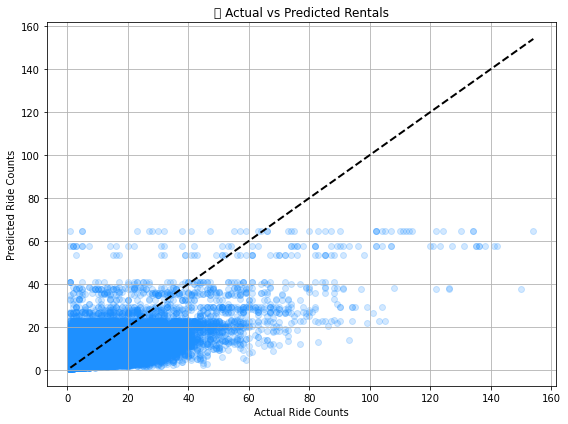

🚴‍♂️ Predicted rentals for station 106 at 8AM Monday: 3


In [7]:
# pip install lightgbm

# === Step 1: Import Required Libraries ===
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# === Step 2: Load and Preprocess the Data ===
#df = pd.read_csv("tfl_cycle_rentals_2021_2023_cleaned.csv", low_memory=False)
df['start_time'] = pd.to_datetime(df['start_time'])

df['hour'] = df['start_time'].dt.hour
df['day_of_week'] = df['start_time'].dt.dayofweek  # 0 = Monday
df['date'] = df['start_time'].dt.date

# === Step 3: Aggregate Data to Get Ride Counts ===
agg_df = df.groupby(['start_station_id', 'hour', 'day_of_week', 'date']).size().reset_index(name='ride_count')

# Clean station ID
agg_df['start_station_id'] = pd.to_numeric(agg_df['start_station_id'], errors='coerce')
agg_df.dropna(subset=['start_station_id'], inplace=True)
agg_df['start_station_id'] = agg_df['start_station_id'].astype(int)

# === Step 4: Feature Engineering ===
X = agg_df[['start_station_id', 'hour', 'day_of_week']]
y = agg_df['ride_count']

# Convert categorical features
X['start_station_id'] = X['start_station_id'].astype('category')
X['hour'] = X['hour'].astype('category')
X['day_of_week'] = X['day_of_week'].astype('category')

# === Step 5: Train-Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === Step 6: Train LightGBM Regressor ===
model = LGBMRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

# === Step 7: Evaluate the Model ===
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"✅ MSE: {mse:.2f}")
print(f"✅ RMSE: {rmse:.2f}")
print(f"✅ R² Score: {r2:.2f}")

# === Step 8: Plot Actual vs Predicted Rentals ===
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.2, color='dodgerblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Ride Counts')
plt.ylabel('Predicted Ride Counts')
plt.title('📊 Actual vs Predicted Rentals')
plt.grid(True)
plt.tight_layout()
plt.show()

# === Step 9: Sample Prediction ===
sample = pd.DataFrame({
    'start_station_id': [106],
    'hour': [8],
    'day_of_week': [0]  # Monday
})
sample['start_station_id'] = sample['start_station_id'].astype('category')
sample['hour'] = sample['hour'].astype('category')
sample['day_of_week'] = sample['day_of_week'].astype('category')

prediction = model.predict(sample)
print(f"🚴‍♂️ Predicted rentals for station 106 at 8AM Monday: {int(prediction[0])}")
